/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde


=== Evaluation Metrics ===
R² Train: 0.962
R² Test: 0.641
MAE Test: 1.213
RMSE Test: 1.299
AIC: 45.495
BIC: 46.087

Best RF Params: {'max_depth': None, 'n_estimators': 100}
Best GB Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


  0%|          | 0/3 [00:00<?, ?it/s]

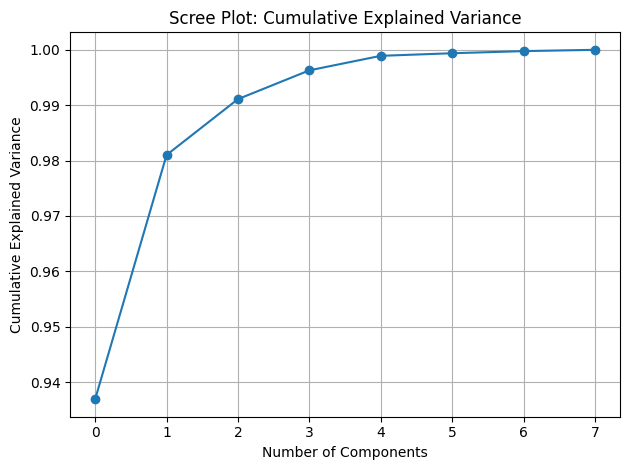

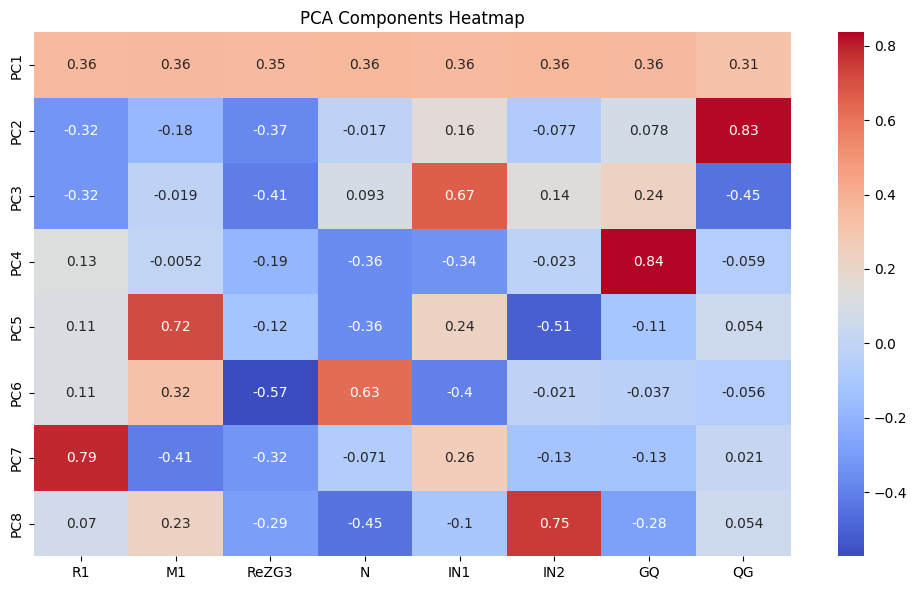

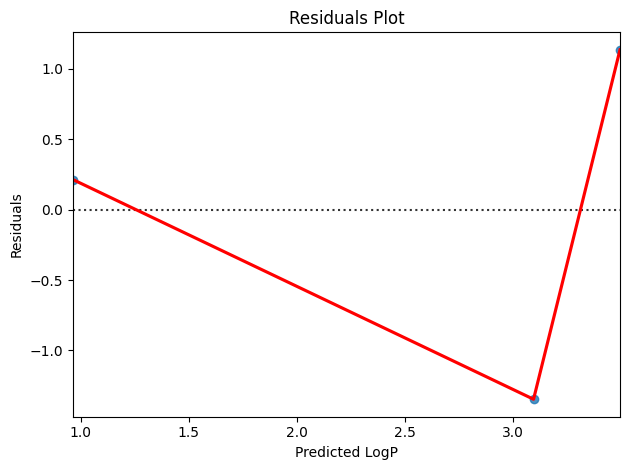

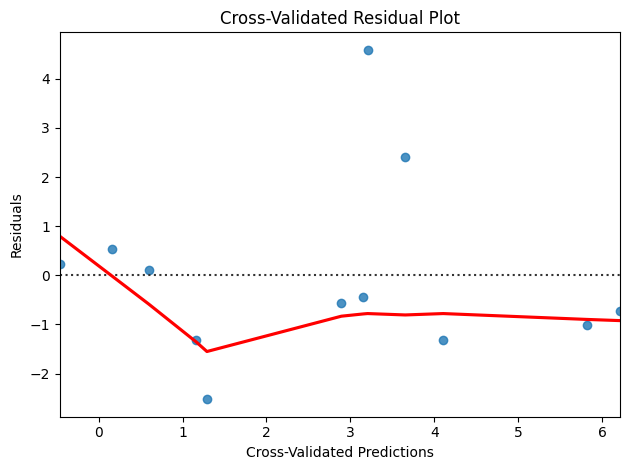

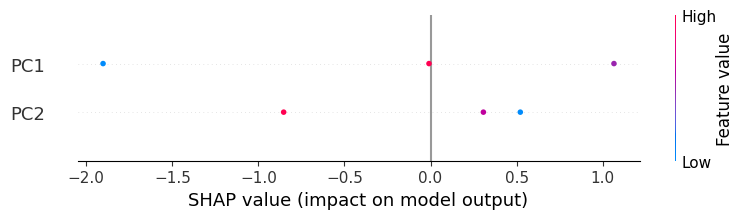

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import shap

# === Load Dataset ===
df = pd.read_csv("normalized_topological_indices_with_logp.csv")
X = df.drop(columns=["LogP"])
y = df["LogP"]

# === PCA ===
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree Plot
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Scree Plot: Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_scree_plot.png")

# PCA Component Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pca.components_, cmap='coolwarm', annot=True,
            xticklabels=X.columns,
            yticklabels=[f'PC{i+1}' for i in range(len(X.columns))])
plt.title("PCA Components Heatmap")
plt.tight_layout()
plt.savefig("pca_component_plot.png")

# Reduce dimensions to retain 95% variance
pca_opt = PCA(n_components=0.95)
X_reduced = pca_opt.fit_transform(X)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.25, random_state=42)

# === Hyperparameter Tuning ===
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10]
}
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5)
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_

# === Ensemble Model ===
ensemble = VotingRegressor([("rf", best_rf), ("gb", best_gb)])
ensemble.fit(X_train, y_train)

y_pred_train = ensemble.predict(X_train)
y_pred_test = ensemble.predict(X_test)

# === Evaluation Metrics ===
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# AIC/BIC approximation
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const).fit()
aic = ols_model.aic
bic = ols_model.bic

print("\n=== Evaluation Metrics ===")
print(f"R² Train: {r2_train:.3f}")
print(f"R² Test: {r2_test:.3f}")
print(f"MAE Test: {mae_test:.3f}")
print(f"RMSE Test: {rmse_test:.3f}")
print(f"AIC: {aic:.3f}")
print(f"BIC: {bic:.3f}")
print("\nBest RF Params:", grid_rf.best_params_)
print("Best GB Params:", grid_gb.best_params_)

# === Residual Plot ===
residuals = y_test - y_pred_test
plt.figure()
sns.residplot(x=y_pred_test, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted LogP")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.tight_layout()
plt.savefig("residual_plot.png")

# === Cross-Validated Residual Plot ===
cv_preds = cross_val_predict(ensemble, X_reduced, y, cv=5)
cv_residuals = y - cv_preds
plt.figure()
sns.residplot(x=cv_preds, y=cv_residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Cross-Validated Predictions")
plt.ylabel("Residuals")
plt.title("Cross-Validated Residual Plot")
plt.tight_layout()
plt.savefig("cv_residual_plot.png")

# === Feature Importances ===
importances_rf = best_rf.feature_importances_
importances_gb = best_gb.feature_importances_
components = [f"PC{i+1}" for i in range(len(importances_rf))]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.barh(components, importances_rf)
plt.title("Random Forest Importances")
plt.subplot(1, 2, 2)
plt.barh(components, importances_gb, color='orange')
plt.title("Gradient Boosting Importances")
plt.tight_layout()
plt.savefig("feature_importances.png")

# === SHAP Explanation (CPU Compatible) ===
explainer = shap.KernelExplainer(best_gb.predict, X_train[:50])  # limit to speed up
shap_values = explainer.shap_values(X_test[:10])
shap.summary_plot(shap_values, X_test[:10], feature_names=components, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.png")
